# Set Required Args to Activate Modules

In [1]:
# Iterate over provinces for both solar and wind resources
resource_types = ['wind','solar']  #'wind','solar'
countries=['AL'] #'AL, 'BA','XK','ME','MK','RS']

In [22]:
import RES.RESources as RES

for country in countries:
    for resource_type in resource_types:
        required_args = {
            "config_file_path": 'config/config.yaml',
            "region_short_code": country,
            "resource_type": resource_type
        }
        
        # Create an instance of Resources and execute the module
        RES_module = RES.RESources_builder(**required_args)
        RES_module.build(select_top_sites=True,
                         use_pypsa_buses=False)

2025-06-04 10:34:37,448 - INFO - Processing Annual Technology Baseline (ATB) data sourced from NREL...
2025-06-04 10:34:37,448 - INFO - Directory 'data/downloaded_data/NREL/ATB/ATBe.parquet' found locally.


2025-06-04 10:34:37,634 - INFO - ATB cost datafile: ATBe.parquet loaded
2025-06-04 10:34:37,839 - INFO - Preparing Grid Cells...
2025-06-04 10:34:37,840 - INFO - >> Loading GADM data for Albania from local datafile data/downloaded_data/GADM/gadm41_Albania_L2.geojson.
2025-06-04 10:34:37,860 - INFO - Cutout already prepared.
2025-06-04 10:34:37,895 - INFO - >> Loading GADM data for Albania from local datafile data/downloaded_data/GADM/gadm41_Albania_L2.geojson.
2025-06-04 10:34:37,917 - INFO - Cutout already prepared.
2025-06-04 10:34:37,917 - INFO - >> Loading global filters' rasters from GAEZ, trimmed to Albania
2025-06-04 10:34:37,918 - INFO - >> Raster file 'faocmb_2010.tif' already exists locally.
2025-06-04 10:34:37,919 - INFO - >> Raster file 'slpmed05.tif' already exists locally.
2025-06-04 10:34:37,919 - INFO - >> Raster file 'exclusion_2017.tif' already exists locally.
2025-06-04 10:34:37,919 - INFO - >> Loading GADM data for Albania from local datafile data/downloaded_data/GA

>> Data saved to data/store/resources_AL.h5 with key 'cost/atb/solar'
>> Data saved to data/store/resources_AL.h5 with key 'cost/atb/wind'
__________________________________________________
 Initiating wind module for Albania...

    >>> Memory management remarks:
    * After execution, all downloaded data is stored at cutout.path. By default, it is not loaded into memory, but into dask arrays. This keeps the memory consumption extremely low.
    * The data is accessible in cutout.data, which is an xarray.Dataset. Querying the cutout gives us some basic information on which data is contained in it.
    * For more operations related to cutout, check the tool docs @ https://atlite.readthedocs.io/en/master/examples/create_cutout.html#
        
>> Converting geometry column 'geometry' to WKT
>> Updated and extended 'cells' saved to data/store/resources_AL.h5
>> Converting geometry column 'geometry' to WKT
>> Updated and extended 'boundary' saved to data/store/resources_AL.h5

    >>> Memor

2025-06-04 10:34:38,013 - INFO - >> Raster plot saved at: vis/misc/faocmb_2010_raster_AL.png
2025-06-04 10:34:38,105 - INFO - >> Raster plot saved at: vis/misc/slpmed05_raster_AL.png
2025-06-04 10:34:38,211 - INFO - >> Raster plot saved at: vis/misc/exclusion_2017_raster_AL.png
2025-06-04 10:34:38,212 - INFO - All required rasters for GAEZ processed and plotted successfully.
2025-06-04 10:34:38,212 - INFO -  >>> Loading Land_cover layers from data/downloaded_data/GAEZ/Rasters_in_use/LR/lco/AL_faocmb_2010.tif
2025-06-04 10:34:38,212 - INFO -  >>> Loading Terrain_resources layers from data/downloaded_data/GAEZ/Rasters_in_use/LR/ter/AL_slpmed05.tif
2025-06-04 10:34:38,213 - INFO -  >>> Loading Exclusion_areas layers from data/downloaded_data/GAEZ/Rasters_in_use/LR/excl/AL_exclusion_2017.tif
2025-06-04 10:34:38,213 - INFO - >> Loading locally stored OSM data for 'aeroway' from data/downloaded_data/OSM/AL_aeroway.geojson
2025-06-04 10:34:38,227 - INFO - Exclusion Container
 registered raste

Land availability (grid cells) map saved at vis/misc/land_availability_ERA5grid_Albania.png


2025-06-04 10:34:40,506 - INFO - >> Saving to the local store (as HDF5 file)
2025-06-04 10:34:40,561 - INFO - Preparing Timeseries for the Cells...
2025-06-04 10:34:40,561 - INFO - >> Loading ERA5 Cutout
2025-06-04 10:34:40,561 - INFO - >> Loading GADM data for Albania from local datafile data/downloaded_data/GADM/gadm41_Albania_L2.geojson.
2025-06-04 10:34:40,581 - INFO - Cutout already prepared.
2025-06-04 10:34:40,600 - INFO - >> 71 Grid Cells from Store Cutout


Land availability map (excluder resolution) saved at vis/misc/land_availability_excluderResolution_Albania.png
>> Total ERA5 cells loaded : 1596 [each with .025 deg. (~30km) resolution ]
>> Converting geometry column 'geometry' to WKT
>> Updated and extended 'cells' saved to data/store/resources_AL.h5

    >>> Memory management remarks:
    * After execution, all downloaded data is stored at cutout.path. By default, it is not loaded into memory, but into dask arrays. This keeps the memory consumption extremely low.
    * The data is accessible in cutout.data, which is an xarray.Dataset. Querying the cutout gives us some basic information on which data is contained in it.
    * For more operations related to cutout, check the tool docs @ https://atlite.readthedocs.io/en/master/examples/create_cutout.html#
        
Fetching Turbine: '3.2M114_NES' data from OEDB
>> Fetching turbine config for: 3.2M114_NES from OEDB


2025-06-04 10:34:45,288 - INFO - adding a cut-out wind speed to the turbine power curve at V=22.0 m/s.
2025-06-04 10:34:45,288 - INFO - Convert and aggregate 'wind'.


>> 3.2M114_NES turbine config saved to 'data/downloaded_data/OEDB/3.2M114_NES.yaml'
>> selected Wind Turbine  Model : 3.2M114 NES @ 93.0m Hub Height
MultiIndex([], names=['time', 'cell'])


2025-06-04 10:34:45,551 - INFO - >> Calculating CF mean from the 8760 data points for each Cell ...
2025-06-04 10:34:45,552 - INFO - >> Total Grid Cells: 71, >> Timeseries Generated for: 71, >> Matched Sites: (8760, 71)
2025-06-04 10:34:45,552 - INFO - >> Calculating 'wind_CF_mean' for 71 Cells...
2025-06-04 10:34:45,618 - INFO - >> Loading GADM data for Albania from local datafile data/downloaded_data/GADM/gadm41_Albania_L2.geojson.
2025-06-04 10:34:45,637 - INFO - Cutout already prepared.
2025-06-04 10:34:45,638 - INFO - 'windspeed_ERA5' already present in the store information.
2025-06-04 10:34:45,648 - INFO - >> Loading GADM data for Albania from local datafile data/downloaded_data/GADM/gadm41_Albania_L2.geojson.
2025-06-04 10:34:45,705 - INFO - >> 0 cells have been filtered due to Windspeed filter [0-50 m/s].
>>> Cleaned data loaded for 561523 GWA cells
2025-06-04 10:34:45,764 - INFO - >> Global Wind Atlas (GWA) Cells loaded. Size: 561523


>> Converting geometry column 'geometry' to WKT
>> Updated and extended 'cells' saved to data/store/resources_AL.h5
>> Updated and extended 'timeseries/wind' saved to data/store/resources_AL.h5

    >>> Memory management remarks:
    * After execution, all downloaded data is stored at cutout.path. By default, it is not loaded into memory, but into dask arrays. This keeps the memory consumption extremely low.
    * The data is accessible in cutout.data, which is an xarray.Dataset. Querying the cutout gives us some basic information on which data is contained in it.
    * For more operations related to cutout, check the tool docs @ https://atlite.readthedocs.io/en/master/examples/create_cutout.html#
        
Error processing CF_IEC1: No data found in bounds.
Error processing CF_IEC2: No data found in bounds.
Error processing CF_IEC3: No data found in bounds.
Error processing IEC_Class_ExLoads: No data found in bounds.


2025-06-04 10:34:45,764 - INFO - >> Mapping 561523 GWA Cells to 71 ERA5 Cells...
2025-06-04 10:34:45,764 - INFO - >> Calculating aggregated values for ERA5 Cell's...
2025-06-04 10:34:46,682 - INFO - >> Loading locally stored OSM data for 'power' from data/downloaded_data/OSM/AL_power.geojson


>> Updated and extended 'cells' saved to data/store/resources_AL.h5


2025-06-04 10:34:47,571 - INFO - >> Loading GADM data for Albania from local datafile data/downloaded_data/GADM/gadm41_Albania_L2.geojson.
2025-06-04 10:34:47,672 - INFO - Cutout already prepared.



    >>> Memory management remarks:
    * After execution, all downloaded data is stored at cutout.path. By default, it is not loaded into memory, but into dask arrays. This keeps the memory consumption extremely low.
    * The data is accessible in cutout.data, which is an xarray.Dataset. Querying the cutout gives us some basic information on which data is contained in it.
    * For more operations related to cutout, check the tool docs @ https://atlite.readthedocs.io/en/master/examples/create_cutout.html#
        


2025-06-04 10:34:48,329 - INFO - >> Preparing spatial clusters for 71 Cells


>> Converting geometry column 'geometry' to WKT
>> Converting geometry column 'centroid' to WKT
>> Converting geometry column 'nearest_connection_point' to WKT
>> Updated and extended 'cells' saved to data/store/resources_AL.h5
>> Converting geometry column 'geometry' to WKT
>> Updated and extended 'lines' saved to data/store/resources_AL.h5
>> Calculating Score for each Cell...
>> Converting geometry column 'geometry' to WKT
>> Data saved to data/store/resources_AL.h5 with key 'cells'
>> Calculating Score for each Cell...
>> Converting geometry column 'geometry' to WKT
>> Data saved to data/store/resources_AL.h5 with key 'cells'
>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone Albania - Optimal k for LCOE_wind based clustering: 4



2025-06-04 10:34:48,502 - INFO -  Preparing Clusters...
2025-06-04 10:34:48,503 - INFO -  Creating cluster for Albania 1/1
2025-06-04 10:34:48,517 - INFO -  Culsters Created and a list generated to map the Cells inside each Cluster...
2025-06-04 10:34:48,527 - INFO - >> Preparing representative profiles for 4 clusters
2025-06-04 10:34:48,584 - INFO - >> Units dictionary created and saved to 'data/units_dictionary.xlsx'
2025-06-04 10:34:48,600 - INFO - >> Preparing spatial clusters for 71 Cells


>>> K-means clustering Elbow plots generated for each region based on the Score for each Cell ...
Optimal-k based on 'LCOE' clustering calculated for 1 zones and saved to cell dataframe.

>>> Mapping the Optimal Number of Clusters for Each region ...
>> Converting geometry column 'geometry' to WKT
>> Data saved to data/store/resources_AL.h5 with key 'clusters/wind'
>> Data saved to data/store/resources_AL.h5 with key 'dissolved_indices/wind'
>> Data saved to data/store/resources_AL.h5 with key 'timeseries/clusters/wind'
>> Updated and extended 'units' saved to data/store/resources_AL.h5
>> Calculating Score for each Cell...
>> Converting geometry column 'geometry' to WKT
>> Data saved to data/store/resources_AL.h5 with key 'cells'
>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone Albania - Optimal k for LCOE_wind based clustering: 4



2025-06-04 10:34:48,720 - INFO -  Preparing Clusters...
2025-06-04 10:34:48,720 - INFO -  Creating cluster for Albania 1/1
2025-06-04 10:34:48,734 - INFO -  Culsters Created and a list generated to map the Cells inside each Cluster...
2025-06-04 10:34:48,744 - INFO - >> Preparing representative profiles for 4 clusters
2025-06-04 10:34:48,816 - INFO - Processing Annual Technology Baseline (ATB) data sourced from NREL...
2025-06-04 10:34:48,816 - INFO - Directory 'data/downloaded_data/NREL/ATB/ATBe.parquet' found locally.


>>> K-means clustering Elbow plots generated for each region based on the Score for each Cell ...
Optimal-k based on 'LCOE' clustering calculated for 1 zones and saved to cell dataframe.

>>> Mapping the Optimal Number of Clusters for Each region ...
>> Converting geometry column 'geometry' to WKT
>> Data saved to data/store/resources_AL.h5 with key 'clusters/wind'
>> Data saved to data/store/resources_AL.h5 with key 'dissolved_indices/wind'
>> Data saved to data/store/resources_AL.h5 with key 'timeseries/clusters/wind'
>>> Selecting TOP Sites to for 20 GW Capacity Investment in BC...
____________________________________________________________________________________________________
Selecting the Top Ranked Sites to invest in 20 GW PV in BC
____________________________________________________________________________________________________
____________________________________________________________
     Top Sites(clusters) from wind module saved to data/store/resources_AL.h5 for Alba

2025-06-04 10:34:48,991 - INFO - ATB cost datafile: ATBe.parquet loaded
2025-06-04 10:34:49,222 - INFO - Preparing Grid Cells...
2025-06-04 10:34:49,223 - INFO - >> Loading GADM data for Albania from local datafile data/downloaded_data/GADM/gadm41_Albania_L2.geojson.
2025-06-04 10:34:49,244 - INFO - Cutout already prepared.
2025-06-04 10:34:49,278 - INFO - >> Loading GADM data for Albania from local datafile data/downloaded_data/GADM/gadm41_Albania_L2.geojson.
2025-06-04 10:34:49,298 - INFO - Cutout already prepared.
2025-06-04 10:34:49,299 - INFO - >> Loading global filters' rasters from GAEZ, trimmed to Albania
2025-06-04 10:34:49,300 - INFO - >> Raster file 'faocmb_2010.tif' already exists locally.


>> Data saved to data/store/resources_AL.h5 with key 'cost/atb/solar'
>> Data saved to data/store/resources_AL.h5 with key 'cost/atb/wind'
__________________________________________________
 Initiating solar module for Albania...

    >>> Memory management remarks:
    * After execution, all downloaded data is stored at cutout.path. By default, it is not loaded into memory, but into dask arrays. This keeps the memory consumption extremely low.
    * The data is accessible in cutout.data, which is an xarray.Dataset. Querying the cutout gives us some basic information on which data is contained in it.
    * For more operations related to cutout, check the tool docs @ https://atlite.readthedocs.io/en/master/examples/create_cutout.html#
        
>> Converting geometry column 'geometry' to WKT
>> Updated and extended 'cells' saved to data/store/resources_AL.h5
>> Converting geometry column 'geometry' to WKT
>> Updated and extended 'boundary' saved to data/store/resources_AL.h5

    >>> Memo

2025-06-04 10:34:49,301 - INFO - >> Raster file 'slpmed05.tif' already exists locally.
2025-06-04 10:34:49,301 - INFO - >> Raster file 'exclusion_2017.tif' already exists locally.
2025-06-04 10:34:49,301 - INFO - >> Loading GADM data for Albania from local datafile data/downloaded_data/GADM/gadm41_Albania_L2.geojson.
2025-06-04 10:34:49,394 - INFO - >> Raster plot saved at: vis/misc/faocmb_2010_raster_AL.png
2025-06-04 10:34:49,484 - INFO - >> Raster plot saved at: vis/misc/slpmed05_raster_AL.png
2025-06-04 10:34:49,591 - INFO - >> Raster plot saved at: vis/misc/exclusion_2017_raster_AL.png
2025-06-04 10:34:49,592 - INFO - All required rasters for GAEZ processed and plotted successfully.
2025-06-04 10:34:49,592 - INFO -  >>> Loading Land_cover layers from data/downloaded_data/GAEZ/Rasters_in_use/LR/lco/AL_faocmb_2010.tif
2025-06-04 10:34:49,593 - INFO -  >>> Loading Terrain_resources layers from data/downloaded_data/GAEZ/Rasters_in_use/LR/ter/AL_slpmed05.tif
2025-06-04 10:34:49,593 - I

Land availability (grid cells) map saved at vis/misc/land_availability_ERA5grid_Albania.png


2025-06-04 10:34:51,807 - INFO - >> Saving to the local store (as HDF5 file)
2025-06-04 10:34:51,861 - INFO - Preparing Timeseries for the Cells...
2025-06-04 10:34:51,861 - INFO - >> Loading ERA5 Cutout
2025-06-04 10:34:51,862 - INFO - >> Loading GADM data for Albania from local datafile data/downloaded_data/GADM/gadm41_Albania_L2.geojson.
2025-06-04 10:34:51,881 - INFO - Cutout already prepared.
2025-06-04 10:34:51,901 - INFO - >> 71 Grid Cells from Store Cutout
2025-06-04 10:34:51,901 - INFO - Convert and aggregate 'pv'.


Land availability map (excluder resolution) saved at vis/misc/land_availability_excluderResolution_Albania.png
>> Total ERA5 cells loaded : 1596 [each with .025 deg. (~30km) resolution ]
>> Converting geometry column 'geometry' to WKT
>> Updated and extended 'cells' saved to data/store/resources_AL.h5

    >>> Memory management remarks:
    * After execution, all downloaded data is stored at cutout.path. By default, it is not loaded into memory, but into dask arrays. This keeps the memory consumption extremely low.
    * The data is accessible in cutout.data, which is an xarray.Dataset. Querying the cutout gives us some basic information on which data is contained in it.
    * For more operations related to cutout, check the tool docs @ https://atlite.readthedocs.io/en/master/examples/create_cutout.html#
        


2025-06-04 10:34:52,356 - INFO - >> Calculating CF mean from the 8760 data points for each Cell ...
2025-06-04 10:34:52,357 - INFO - >> Total Grid Cells: 71, >> Timeseries Generated for: 71, >> Matched Sites: (8760, 71)
2025-06-04 10:34:52,358 - INFO - >> Calculating 'solar_CF_mean' for 71 Cells...
2025-06-04 10:34:52,424 - INFO - >> Loading GADM data for Albania from local datafile data/downloaded_data/GADM/gadm41_Albania_L2.geojson.
2025-06-04 10:34:52,443 - INFO - Cutout already prepared.
2025-06-04 10:34:52,443 - INFO - GWA Cells not configured for solar.
2025-06-04 10:34:52,456 - INFO - >> Loading locally stored OSM data for 'power' from data/downloaded_data/OSM/AL_power.geojson


MultiIndex([], names=['time', 'cell'])
>> Converting geometry column 'geometry' to WKT
>> Updated and extended 'cells' saved to data/store/resources_AL.h5
>> Updated and extended 'timeseries/solar' saved to data/store/resources_AL.h5

    >>> Memory management remarks:
    * After execution, all downloaded data is stored at cutout.path. By default, it is not loaded into memory, but into dask arrays. This keeps the memory consumption extremely low.
    * The data is accessible in cutout.data, which is an xarray.Dataset. Querying the cutout gives us some basic information on which data is contained in it.
    * For more operations related to cutout, check the tool docs @ https://atlite.readthedocs.io/en/master/examples/create_cutout.html#
        


2025-06-04 10:34:53,323 - INFO - >> Loading GADM data for Albania from local datafile data/downloaded_data/GADM/gadm41_Albania_L2.geojson.
2025-06-04 10:34:53,342 - INFO - Cutout already prepared.



    >>> Memory management remarks:
    * After execution, all downloaded data is stored at cutout.path. By default, it is not loaded into memory, but into dask arrays. This keeps the memory consumption extremely low.
    * The data is accessible in cutout.data, which is an xarray.Dataset. Querying the cutout gives us some basic information on which data is contained in it.
    * For more operations related to cutout, check the tool docs @ https://atlite.readthedocs.io/en/master/examples/create_cutout.html#
        


2025-06-04 10:34:53,959 - INFO - >> Preparing spatial clusters for 71 Cells
2025-06-04 10:34:54,075 - INFO -  Preparing Clusters...
2025-06-04 10:34:54,075 - INFO -  Creating cluster for Albania 1/1
2025-06-04 10:34:54,089 - INFO -  Culsters Created and a list generated to map the Cells inside each Cluster...


>> Converting geometry column 'geometry' to WKT
>> Converting geometry column 'centroid' to WKT
>> Converting geometry column 'nearest_connection_point' to WKT
>> Updated and extended 'cells' saved to data/store/resources_AL.h5
>> Converting geometry column 'geometry' to WKT
>> Updated and extended 'lines' saved to data/store/resources_AL.h5
>> Calculating Score for each Cell...
>> Converting geometry column 'geometry' to WKT
>> Data saved to data/store/resources_AL.h5 with key 'cells'
>> Calculating Score for each Cell...
>> Converting geometry column 'geometry' to WKT
>> Data saved to data/store/resources_AL.h5 with key 'cells'
>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone Albania - Optimal k for LCOE_solar based clustering: 4

>>> K-means clustering Elbow plots generated for each region based on the Score for each Cell ...
Optimal-k based on 'LCOE' clustering calculated for 1 zones and saved to cell dataframe.

>>> Mapping the Opt

2025-06-04 10:34:54,100 - INFO - >> Preparing representative profiles for 4 clusters
2025-06-04 10:34:54,129 - INFO - >> Units dictionary created and saved to 'data/units_dictionary.xlsx'
2025-06-04 10:34:54,150 - INFO - >> Preparing spatial clusters for 71 Cells
2025-06-04 10:34:54,280 - INFO -  Preparing Clusters...
2025-06-04 10:34:54,280 - INFO -  Creating cluster for Albania 1/1
2025-06-04 10:34:54,294 - INFO -  Culsters Created and a list generated to map the Cells inside each Cluster...


>> Data saved to data/store/resources_AL.h5 with key 'clusters/solar'
>> Data saved to data/store/resources_AL.h5 with key 'dissolved_indices/solar'
>> Data saved to data/store/resources_AL.h5 with key 'timeseries/clusters/solar'
>> Updated and extended 'units' saved to data/store/resources_AL.h5
>> Calculating Score for each Cell...
>> Converting geometry column 'geometry' to WKT
>> Data saved to data/store/resources_AL.h5 with key 'cells'
>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone Albania - Optimal k for LCOE_solar based clustering: 4

>>> K-means clustering Elbow plots generated for each region based on the Score for each Cell ...
Optimal-k based on 'LCOE' clustering calculated for 1 zones and saved to cell dataframe.

>>> Mapping the Optimal Number of Clusters for Each region ...
>> Converting geometry column 'geometry' to WKT


2025-06-04 10:34:54,305 - INFO - >> Preparing representative profiles for 4 clusters


>> Data saved to data/store/resources_AL.h5 with key 'clusters/solar'
>> Data saved to data/store/resources_AL.h5 with key 'dissolved_indices/solar'
>> Data saved to data/store/resources_AL.h5 with key 'timeseries/clusters/solar'
>>> Selecting TOP Sites to for 10 GW Capacity Investment in BC...
____________________________________________________________________________________________________
Selecting the Top Ranked Sites to invest in 10 GW PV in BC
____________________________________________________________________________________________________
____________________________________________________________
     Top Sites(clusters) from solar module saved to data/store/resources_AL.h5 for Albania...
____________________________________________________________
solar clusters exported to :results/linking


In [3]:
# self.get_grid_cells()
# self.get_cell_capacity()
# self.get_CF_timeseries()
# self.extract_weather_data()
# self.update_gwa_scaled_params(self.memory_resource_limitation)
# self.find_grid_nodes(use_pypsa_buses=False)
# self.score_cells()
# self.get_clusters()
# self.get_cluster_timeseries()

In [20]:
# RES_module.get_grid_cells()
# RES_module.get_cell_capacity()

In [7]:
from RES.hdf5_handler import DataHandler
store=f"data/store/resources_{countries[0]}.h5"
res_data=DataHandler(store)

In [23]:

cells=res_data.from_store('cells')
boundary=res_data.from_store('boundary')
lines=res_data.from_store('lines')
solar_clusters=res_data.from_store('clusters/solar')
wind_clusters=res_data.from_store('clusters/wind')
solar_clusters_ts=res_data.from_store('timeseries/clusters/solar')
wind_clusters_ts=res_data.from_store('timeseries/clusters/wind')

In [24]:
resource_clusters_solar,cluster_timeseries_solar=RES_module.select_top_sites(solar_clusters,
                                                                solar_clusters_ts,
                                                                    resource_max_capacity=10)

resource_clusters_wind,cluster_timeseries_wind=RES_module.select_top_sites(wind_clusters,
                                                                wind_clusters_ts,
                                                                    resource_max_capacity=20)

>>> Selecting TOP Sites to for 10 GW Capacity Investment in BC...
____________________________________________________________________________________________________
Selecting the Top Ranked Sites to invest in 10 GW PV in BC
____________________________________________________________________________________________________
>>> Selecting TOP Sites to for 20 GW Capacity Investment in BC...
____________________________________________________________________________________________________
Selecting the Top Ranked Sites to invest in 20 GW PV in BC
____________________________________________________________________________________________________


In [25]:
resource_clusters_wind

,geometry,lcoe,capex,fom,vom,CF_mean,Cluster_No,potential_capacity,Country,nearest_connection_point,nearest_connection_distance,Rank,Operational_life
0,"MULTIPOLYGON (((19.5907 40.1615, 19.5792 40.17...",0.103025,1.564557,0,0.0404,0.126640,1,3306.770611,Albania,POINT (19.4569650000000003 40.3272422000000006),0.220909,1,20
1,"MULTIPOLYGON (((19.6516 40.1285, 19.6475 40.13...",0.299587,1.564557,0,0.0404,0.041099,2,2131.292734,Albania,POINT (19.7311003999999990 40.2216491000000005),0.034073,2,20
3,"MULTIPOLYGON (((20.401 39.8406, 20.4088 39.835...",0.915033,1.564557,0,0.0404,0.013400,4,406.348427,Albania,POINT (20.1923701109317335 41.8397052149180055),0.106622,3,20
2,"MULTIPOLYGON (((20.4088 39.8353, 20.4044 39.82...",1.020364,1.564557,0,0.0404,0.012507,3,567.205535,Albania,POINT (20.1923701109317335 41.8397052149180055),0.106622,4,20


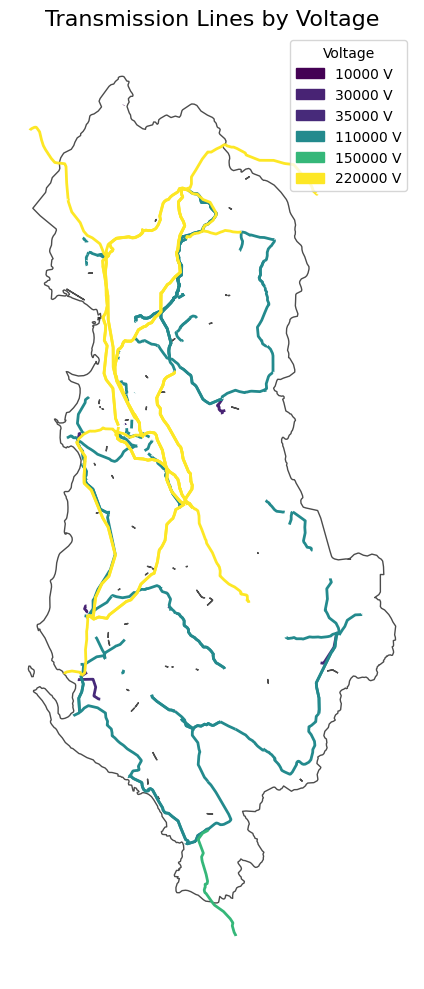

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 10))
boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, alpha=0.7)

if 'voltage' in lines.columns:
    # Convert voltages to numeric, coerce errors to NaN, then drop NaN
    voltages = pd.to_numeric(lines['voltage'], errors='coerce').dropna().unique()
    voltages.sort()
    cmap = plt.cm.viridis
    norm = plt.Normalize(voltages.min(), voltages.max())
    colors = [cmap(norm(v)) for v in voltages]
    for v, color in zip(voltages, colors):
        lines[pd.to_numeric(lines['voltage'], errors='coerce') == v].plot(ax=ax, color=color, linewidth=2, label=str(int(v)))
    legend_patches = [mpatches.Patch(color=color, label=f"{int(v)} V") for v, color in zip(voltages, colors)]
    ax.legend(handles=legend_patches, title='Voltage')
    ax.set_title('Transmission Lines by Voltage', fontsize=16)
else:
    lines.plot(ax=ax, color='blue', linewidth=1)
    ax.set_title('Transmission Lines', fontsize=16)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def add_compass_4326(ax, location=(0.9, 0.15), size=0.05, textsize=9, color='gray'):
    """
    Adds a clean compass rose (N, E, S, W) to a plot in EPSG:4326.
    
    Parameters:
    - ax: The matplotlib Axes.
    - location: (x, y) in Axes fraction coordinates (0–1).
    - size: Radius of the compass arms in axes fraction units.
    - textsize: Font size for cardinal labels.
    - color: Line and label color (default: 'gray').
    """
    cx, cy = location
    r = size

    # Cardinal directions with angles assuming N is up
    directions = {'N': 90, 'E': 180, 'S': 270, 'W': 0}

    for label, angle in directions.items():
        theta = np.deg2rad(angle)
        dx = r * np.cos(theta)
        dy = r * np.sin(theta)

        # Draw line from center to direction
        ax.plot([cx, cx + dx], [cy, cy + dy], transform=ax.transAxes,
                color=color, linewidth=0.8)

        # Draw text slightly outside the tip
        ax.text(cx + 1.25 * dx, cy + 1.25 * dy, label,
                transform=ax.transAxes,
                ha='center', va='center',
                fontsize=textsize, fontweight='medium',
                color=color, family='sans-serif')

    # Small center dot
    ax.plot(cx, cy, 'o', transform=ax.transAxes, color=color, markersize=2)


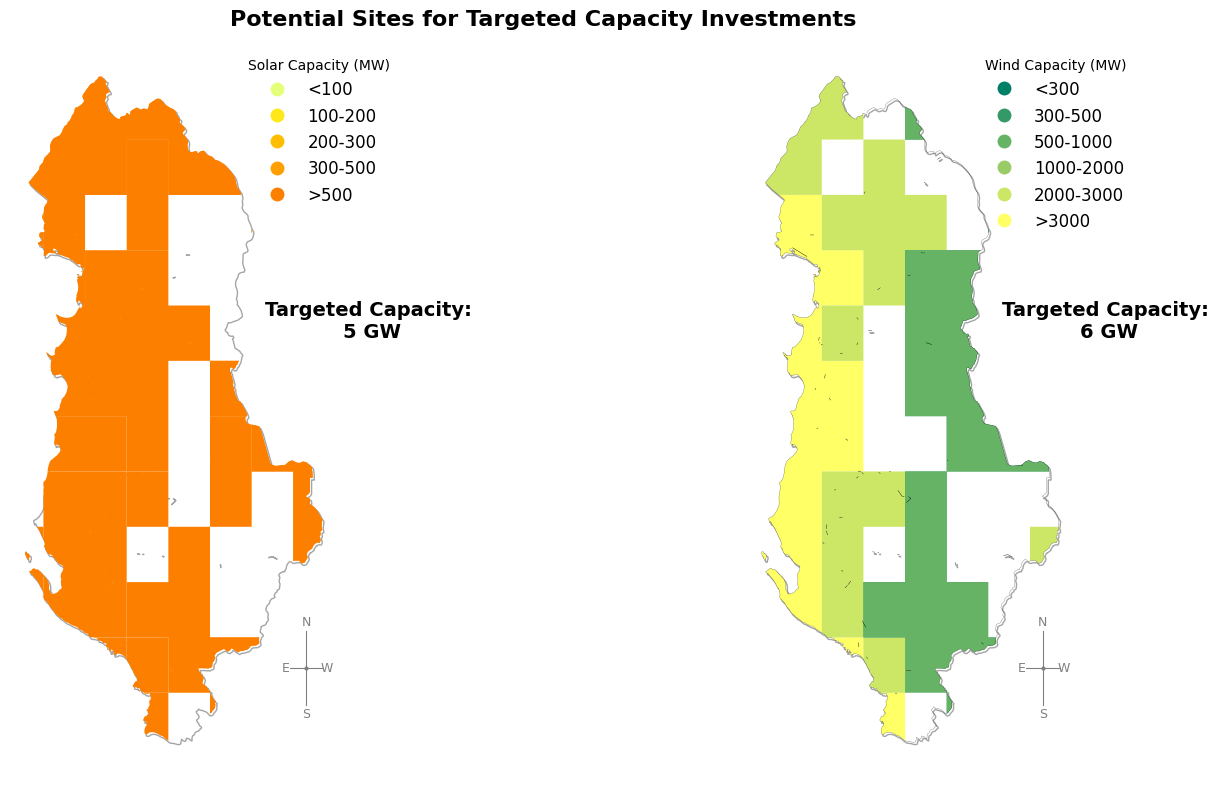

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

legend_x_ax_offset=1.2

# Ensure 'Region' is in the columns for both boundary and cells
# if boundary is not None and ('Region' not in boundary.columns or 'Country' not in boundary.columns):
#     boundary = boundary.reset_index()

# Assign a number to each region
# boundary['Region_Number'] = range(1, len(boundary) + 1)

# Define custom bins and labels for solar and wind capacity
solar_bins = [0, 100, 200, 300, 500, float('inf')]  # Custom ranges
solar_labels = ['<100','100-200', '200-300', '300-500','>500']  # Labels for legend

# Define custom bins and labels for solar and wind capacity
wind_bins = [0, 300, 500, 1000, 2000,3000, float('inf')]  # Custom ranges
wind_labels = ['<300','300-500', '500-1000', '1000-2000','2000-3000', '>3000']  # Labels for legend

# Categorize potential_capacity_solar and potential_capacity_wind into bins
resource_clusters_solar['solar_category'] = pd.cut(resource_clusters_solar['potential_capacity'], bins=solar_bins, labels=solar_labels, include_lowest=True)
resource_clusters_wind['wind_category'] = pd.cut(resource_clusters_wind['potential_capacity'], bins=wind_bins, labels=wind_labels, include_lowest=True)

# Create figure and axes for side-by-side plotting
fig, (ax1, ax2) = plt.subplots(figsize=(18, 8), ncols=2)
fig.suptitle("Potential Sites for Targeted Capacity Investments", fontsize=16,weight='bold')
# Set axis off for both subplots
ax1.set_axis_off()
ax2.set_axis_off()

# Shadow effect offset
shadow_offset = 0.01

# Plot solar map on ax1
# Add shadow effect for solar map
boundary.geometry = boundary.geometry.translate(xoff=shadow_offset, yoff=-shadow_offset)
boundary.plot(ax=ax1, color='None', edgecolor='grey', linewidth=1, alpha=0.7)  # Shadow layer
boundary.geometry = boundary.geometry.translate(xoff=-shadow_offset, yoff=shadow_offset)

# Plot solar cells
resource_clusters_solar.plot(column='solar_category', ax=ax1, cmap='Wistia', legend=True, 
           legend_kwds={'title': "Solar Capacity (MW)", 'loc': 'upper right','fontsize':12,'bbox_to_anchor':(legend_x_ax_offset,1), 'frameon': False})

# Plot actual boundary for solar map
# boundary.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.2, alpha=0.7)
"""
# Annotate region numbers for solar map
for idx, row in boundary.iterrows():
    centroid = row.geometry.centroid
    ax1.annotate(f"{row['Region_Number']}", 
                 xy=(centroid.x, centroid.y), 
                 ha='center', va='center',
                 fontsize=7, color='black',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2'))
"""
# Plot wind map on ax2
# Add shadow effect for wind map
boundary.geometry = boundary.geometry.translate(xoff=shadow_offset, yoff=-shadow_offset)
boundary.plot(ax=ax2, color='None', edgecolor='grey', linewidth=1, alpha=0.7)  # Shadow layer
boundary.geometry = boundary.geometry.translate(xoff=-shadow_offset, yoff=shadow_offset)

# Plot wind cells
resource_clusters_wind.plot(column='wind_category', ax=ax2, cmap='summer', legend=True, 
           legend_kwds={'title': "Wind Capacity (MW)", 'fontsize':12,'bbox_to_anchor':(legend_x_ax_offset,1), 'frameon': False})

# Plot actual boundary for wind map
boundary.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.2, alpha=0.7)
"""
# Annotate region numbers for wind map
for idx, row in boundary.iterrows():
    centroid = row.geometry.centroid
    ax2.annotate(f"{row['Region_Number']}", 
                 xy=(centroid.x, centroid.y), 
                 ha='center', va='center',
                 fontsize=8, color='black',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2'))
"""
# Adjust layout for cleaner appearance
fig.patch.set_alpha(0)  # Make figure background transparent
plt.tight_layout()


# Add annotation for solar capacity
ax1.annotate(f"Targeted Capacity: \n{int(resource_clusters_solar.potential_capacity.sum()/1e3)} GW",
             xy=(1.1, 0.6), xycoords='axes fraction', ha='center', 
             fontsize=14, color='black', fontweight='bold')

# Add annotation for wind capacity
ax2.annotate(f"Targeted Capacity: \n{int(resource_clusters_wind.potential_capacity.sum()/1e3)} GW",
             xy=(1.1, 0.6), xycoords='axes fraction', ha='center', 
             fontsize=14, color='black', fontweight='bold')
# Show the side-by-side plot

plt.savefig('vis/solar_wind_capacity_map.png',dpi=300)
# Add a directional compass (north arrow) to both subplots
# Use a more standard north arrow style
add_compass_4326(ax1, location=(0.9, 0.15), size=0.05)
add_compass_4326(ax2, location=(0.9, 0.15), size=0.05)
plt.show()

In [29]:
wind_clusters.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [30]:
cells.columns

Index(['x', 'y', 'Country', 'geometry', 'wind_CF_mean', 'windspeed_ERA5',
       'windspeed_gwa', 'x_2', 'y_2', 'windspeed_gwa_1', 'windspeed_gwa_2',
       'centroid', 'nearest_connection_distance', 'nearest_connection_point',
       'Operational_life_wind', 'capex_wind', 'fom_wind',
       'grid_connection_cost_per_km_wind', 'potential_capacity_wind',
       'tx_line_rebuild_cost_wind', 'vom_wind', 'lcoe_wind',
       'Operational_life_solar', 'capex_solar', 'fom_solar',
       'grid_connection_cost_per_km_solar', 'potential_capacity_solar',
       'tx_line_rebuild_cost_solar', 'vom_solar', 'solar_CF_mean',
       'lcoe_solar', 'nearest_distance', 'Region'],
      dtype='object')

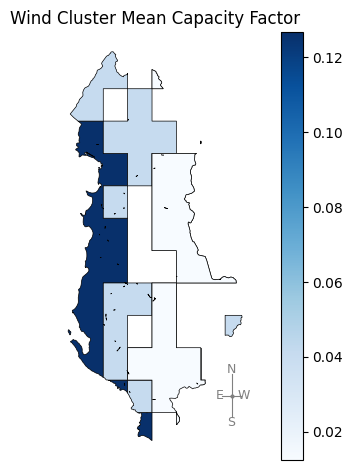

In [31]:
ax = wind_clusters.plot(column='CF_mean', cmap='Blues', legend=True, edgecolor='black', linewidth=0.5)
ax.set_title("Wind Cluster Mean Capacity Factor", fontsize=12)
ax.set_axis_off()
add_compass_4326(ax, location=(0.9, 0.15), size=0.05)
plt.tight_layout()
plt.show()

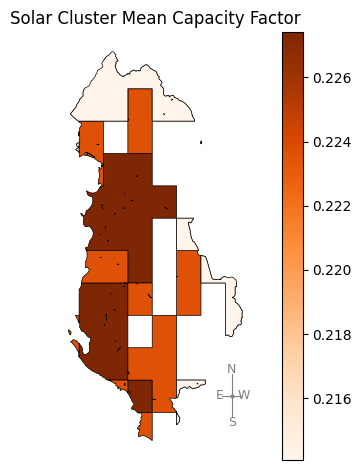

In [32]:
ax =solar_clusters.plot(column='CF_mean', cmap='Oranges', legend=True, edgecolor='black', linewidth=0.5)
ax.set_title("Solar Cluster Mean Capacity Factor", fontsize=12)
ax.set_axis_off()
add_compass_4326(ax, location=(0.9, 0.15), size=0.05)
plt.tight_layout()
plt.show()